<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Training-Function" data-toc-modified-id="Training-Function-2">Training Function</a></span></li><li><span><a href="#Circle-generator" data-toc-modified-id="Circle-generator-3">Circle generator</a></span></li><li><span><a href="#Task-1:-9-Neurons" data-toc-modified-id="Task-1:-9-Neurons-4">Task 1: 9 Neurons</a></span><ul class="toc-item"><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-4.1">Train Model</a></span></li><li><span><a href="#Efficiency-Evaluation" data-toc-modified-id="Efficiency-Evaluation-4.2">Efficiency Evaluation</a></span></li></ul></li><li><span><a href="#Task-2:-3-Neurons" data-toc-modified-id="Task-2:-3-Neurons-5">Task 2: 3 Neurons</a></span><ul class="toc-item"><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-5.1">Train Model</a></span></li><li><span><a href="#Efficiency-Evaluation" data-toc-modified-id="Efficiency-Evaluation-5.2">Efficiency Evaluation</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-5.3">Train Model</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6">Summary</a></span></li></ul></div>

# Autoencoders - Wk. 4 Pt. 2

## Introduction

Author: SL

Last Edited: 03.11.2021

Link to this notebook on GitHub: https://github.com/SL023/MLforPhys/blob/main/Week4_AutoencoderChallenge.ipynb

<u><b>Task Description</b></u>


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

**Task 1:**
Implement any network design, but the bottleneck must contain no more than 9 neurons.

**Task 2:**
Implement any network design, but the bottleneck must contain no more than 3 neurons.

**Practicalities** You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
# import relevant modules
import matplotlib.pyplot as plt
import numpy as np
import math 

# tensorFlow and tf.keras for neural network
import tensorflow as tf
from tensorflow import keras

# adjusting style of plots
import matplotlib.style
import matplotlib as mpl 

mpl.rcParams['figure.figsize'] = [4.0, 3.0] 
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200
plt.style.use('bmh')

## Training Function

The following function is copied from the original task notebook: https://github.com/nichol77/mlForPhysicists/blob/master/Week4/Week4_Autoencoder.ipynb

In [2]:
'''
A big messy function to do the training
model -- our keras neural model autoencoder
image_generator -- a function to generate random images for the training (see below for examples)
img_size -- the size of our image in pixels
batchsize -- the number of images to include in each training batch
steps -- the number of steps taken in the training

returns an array of the costs
'''

def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator

Again, the following code is copied directly from the original task notebook.

In [3]:
'''A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)'''
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

## Task 1: 9 Neurons

For this task, we begin by creating a sequential model in a similar way to the original task notebook. 

Since the input image size is 27 x 27 pixel images, we use `MaxPooling2D` with a pool size of (3,3) twice, obtaining a shape of 3 x 3, and so if we have a filter of 1 in the convolutional layer after 3 poolings, we obtain 3 x 3 x 1 = 9 neurons, as required. 

We then use `UpSampling2D` with a size of (3,3) twice to obtain an output image size of 27 x 27 to match the original input. 

In order to achieve a target of less than 0.02 efficiently, we use 128 filters in all the convolutional layers except the one in the middle (for obtaining 9 neurons in the 'bottleneck') and the final layer. 

We also use the ReLU activation function for all layers. The reasoning for this is the same as Week 2's task, where we achieved a better output for the circle generation using the ReLU activation function. 

In [4]:
# create sequential model
model = keras.models.Sequential()

# specify layers to add to model

# 27 * 27 * 128
model.add(keras.layers.Conv2D(128,(3,3),input_shape=(None,None,1),activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) 
# 9 * 9 * 128
model.add(keras.layers.Conv2D(128,(3,3), activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same'))
# 3 * 3 * 1
model.add(keras.layers.Conv2D(1,(3,3), activation="relu",padding='same'))
# 3 * 3 * 128
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) 
# 9 * 9 * 128
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3)))
# 27 * 27 * 1
model.add(keras.layers.Conv2D(1,(3,3),activation="relu",padding='same'))

# compile model and specify the loss function of MSE and optimizer of adam
model.compile(loss='mean_squared_error',optimizer='adam')

# summarise the layers, output shape and parameters of the network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1153      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   1280      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 128)   0

### Train Model

Final Cost:  0.013965612277388573


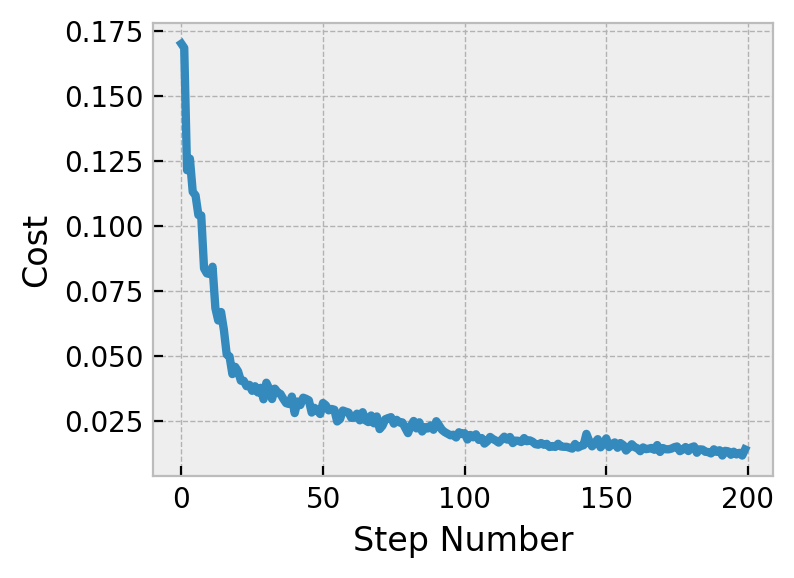

In [5]:
# training model using specified batchsize and step size
steps=200
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=100,steps=steps)
# plot cost against step number of training
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost");
# output final cost value
print("Final Cost: ", cost[-1])

In [6]:
# output layers and neurons in model
print_layers(model,y_target)

Layer 0: 93312 neurons /  (100, 27, 27, 128)
Layer 1: 10368 neurons /  (100, 9, 9, 128)
Layer 2: 10368 neurons /  (100, 9, 9, 128)
Layer 3: 1152 neurons /  (100, 3, 3, 128)
Layer 4: 9 neurons /  (100, 3, 3, 1)
Layer 5: 1152 neurons /  (100, 3, 3, 128)
Layer 6: 10368 neurons /  (100, 9, 9, 128)
Layer 7: 10368 neurons /  (100, 9, 9, 128)
Layer 8: 93312 neurons /  (100, 27, 27, 128)
Layer 9: 729 neurons /  (100, 27, 27, 1)


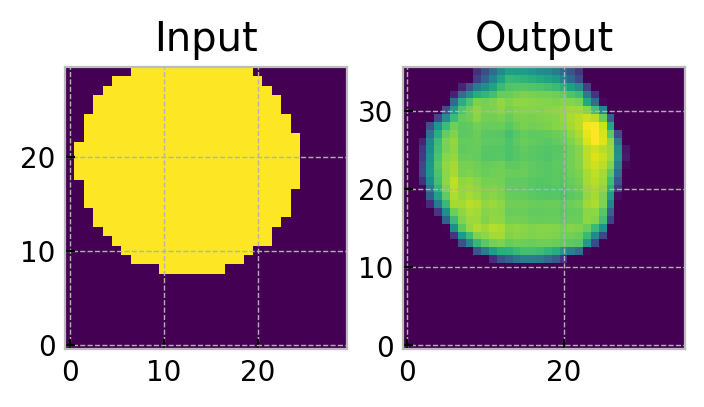

In [7]:
# display a test input and output image
plot_test_image(model,circle_generator,30)

**Conclusion**

We see that we are able to create an autoencoder such that we have 9 neurons in the 'bottleneck' and are able to achieve a cost function of ~0.01, which satisfies the target of 0.02. 

Note: It is possible to obtain the target using only 64 filters in each convolutional layer, however we see that this has a lower performance when comparing the input and output images, thus 128 is used instead. 

### Efficiency Evaluation

We can evaluate the effect of improving the efficiency and simplicity of the network by reducing the number of steps to 100 and number of filters in the convolutional layers to 64. 

In [8]:
# create sequential model
model = keras.models.Sequential()

# specify layers to add to model

# 27 * 27 * 64
model.add(keras.layers.Conv2D(64,(3,3),input_shape=(None,None,1),activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) 
# 9 * 9 * 64
model.add(keras.layers.Conv2D(64,(3,3), activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same'))
# 3 * 3 * 1
model.add(keras.layers.Conv2D(1,(3,3), activation="relu",padding='same'))
# 3 * 3 * 64
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) 
# 9 * 9 * 64
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3)))
# 27 * 27 * 1
model.add(keras.layers.Conv2D(1,(3,3),activation="relu",padding='same'))

# compile model and specify the loss function of MSE and optimizer of adam
model.compile(loss='mean_squared_error',optimizer='adam')

# summarise the layers, output shape and parameters of the network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 1)     577       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, None, None, 64)   

Final Cost:  0.022177595645189285


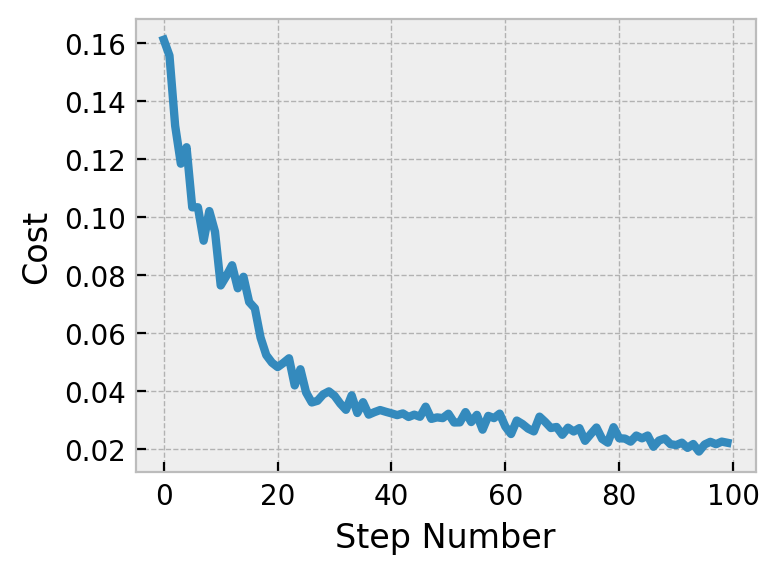

In [9]:
# training model using specified batchsize and step size
steps=100
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=100,steps=steps)
# plot cost against step number of training
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost");
# output final cost value
print("Final Cost: ", cost[-1])

In [10]:
# output layers and neurons in model
print_layers(model,y_target)

Layer 0: 46656 neurons /  (100, 27, 27, 64)
Layer 1: 5184 neurons /  (100, 9, 9, 64)
Layer 2: 5184 neurons /  (100, 9, 9, 64)
Layer 3: 576 neurons /  (100, 3, 3, 64)
Layer 4: 9 neurons /  (100, 3, 3, 1)
Layer 5: 576 neurons /  (100, 3, 3, 64)
Layer 6: 5184 neurons /  (100, 9, 9, 64)
Layer 7: 5184 neurons /  (100, 9, 9, 64)
Layer 8: 46656 neurons /  (100, 27, 27, 64)
Layer 9: 729 neurons /  (100, 27, 27, 1)


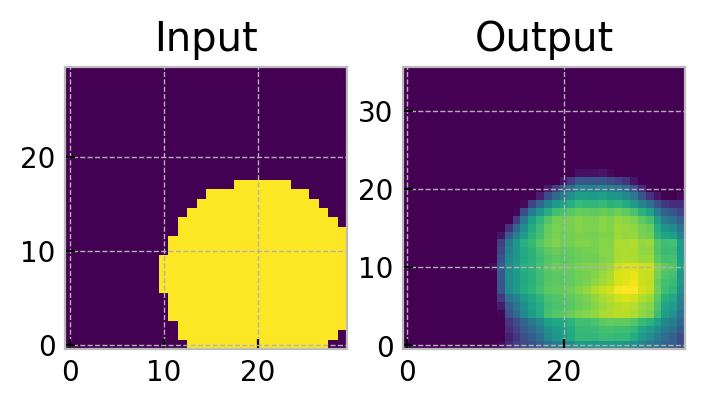

In [11]:
# display a test input and output image
plot_test_image(model,circle_generator,30)

We see that we are able to achieve a cost function of ~0.02 with just 100 steps and 64 filters, and the output image still looks similar to the input image. Thus, this is more efficient and still satisfies the target cost function, although the cost function is still higher than previous. 

## Task 2: 3 Neurons

For this task, to obtain 3 Neurons in the 'bottlneck' of our autoencoder, we need to down-sample one more time than the previous task, and correspondingly up-sample an additional time. This is so that we obtain an image size of 1 x 1 such that if we have 3 filters in our convolutional layer, we will have 3 neurons in total. 

Thus, we use `MaxPooling2D` with a pool size of (3,3) thrice, and then use `UpSampling2D` with a size of (3,3) thrice to obtain an output image size of 27 x 27 to match the original input. The remaining network remains similar to the previous task, other than the change in the number of filters in the convolutional layers. 

In [12]:
# create sequential model
model = keras.models.Sequential()

# specify layers to add to model

# 27 * 27 * 
model.add(keras.layers.Conv2D(128,(3,3),input_shape=(None,None,1),activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) 
# 9 * 9 *
model.add(keras.layers.Conv2D(64,(3,3), activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same'))
# 3 * 3 * 
model.add(keras.layers.Conv2D(32,(3,3), activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same'))
# 1 * 1 * 3
model.add(keras.layers.Conv2D(3,(3,3), activation="relu",padding='same'))
# 1 * 1 * 
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) 
# 3 * 3 * 
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3)))
# 9 * 9 * 
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3)))
# 27 * 27 * 
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding='same'))

# compile model and specify the loss function of MSE and optimizer of adam
model.compile(loss='mean_squared_error',optimizer='adam')

# summarise the layers, output shape and parameters of the network
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, None, None, 128)   1280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 64)    73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, None, 3)    

### Train Model

We train the model in the same way as before, noting that we increase the number of steps to 300 since there are a greater number of neurons in our network, so it takes more steps for the cost to converge due to the higher complexity. 

Final Cost:  0.023874953389167786


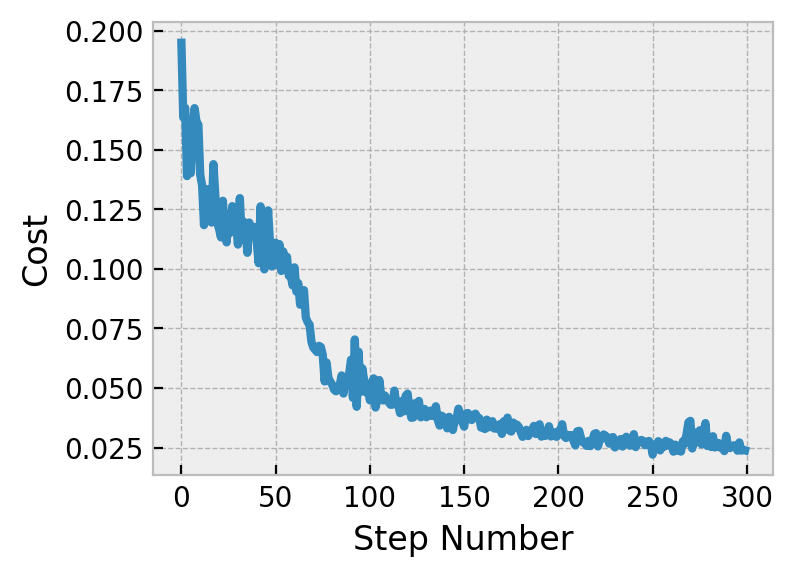

In [13]:
# training model using specified batchsize and step size
steps=300
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=100,steps=steps)
# plot cost against step number of training
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost");
# output final cost value
print("Final Cost: ", cost[-1])

In [14]:
# output layers and neurons in model
print_layers(model,y_target)

Layer 0: 93312 neurons /  (100, 27, 27, 128)
Layer 1: 10368 neurons /  (100, 9, 9, 128)
Layer 2: 5184 neurons /  (100, 9, 9, 64)
Layer 3: 576 neurons /  (100, 3, 3, 64)
Layer 4: 288 neurons /  (100, 3, 3, 32)
Layer 5: 32 neurons /  (100, 1, 1, 32)
Layer 6: 3 neurons /  (100, 1, 1, 3)
Layer 7: 128 neurons /  (100, 1, 1, 128)
Layer 8: 1152 neurons /  (100, 3, 3, 128)
Layer 9: 576 neurons /  (100, 3, 3, 64)
Layer 10: 5184 neurons /  (100, 9, 9, 64)
Layer 11: 2592 neurons /  (100, 9, 9, 32)
Layer 12: 23328 neurons /  (100, 27, 27, 32)
Layer 13: 46656 neurons /  (100, 27, 27, 64)


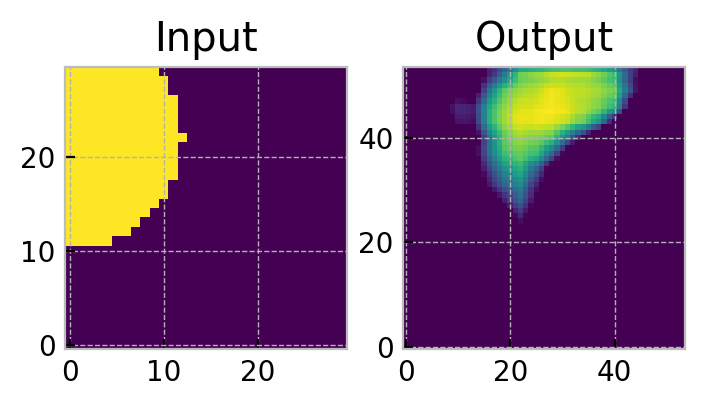

In [15]:
# display a test input and output image
plot_test_image(model,circle_generator,30)

We see that since the autoencoder has only 3 neurons in its 'bottleneck' we obtain a worse output image and higher cost value, since the image of 27 x 27 is being reduced to only 1 x 1, thus compressing significant information. 

We are able to obtain a cost of ~0.02 however this model takes much longer to train and thus is not as efficient. 

### Efficiency Evaluation

To increase the network simplicty and efficiency for this task, we cannot reduce the number of steps as this results in a higher cost value (see below). 

Instead, we reduce the number of filters in the convolutional layers to 32 and 3, and also increase the kernel size to 5 and 7 at various layers. 

Finally, we also remove two convolutional layers in our network as these are unnecessary and do not affect the performance of the network, thus we do not require this additional computation. 

In [20]:
# create sequential model
model = keras.models.Sequential()

# specify layers to add to model

# 27 * 27 * 32
model.add(keras.layers.Conv2D(32,(5,5),input_shape=(None,None,1),activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) 
# 9 * 9 * 32
model.add(keras.layers.Conv2D(32,(7,7), activation="relu",padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same'))
# 3 * 3 * 3
model.add(keras.layers.Conv2D(3,(3,3), activation="relu",padding='same'))
# 1 * 1 * 3
model.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same'))
# 3 * 3 * 3
model.add(keras.layers.UpSampling2D(size=(3,3))) 
# 9 * 9 * 32
model.add(keras.layers.Conv2D(32,(5,5),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3)))
# 27 * 27 * 32
model.add(keras.layers.Conv2D(32,(7,7),activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3)))
# 27 * 27 * 3
model.add(keras.layers.Conv2D(3,(3,3),activation="relu",padding='same'))

# compile model and specify the loss function of MSE and optimizer of adam
model.compile(loss='mean_squared_error',optimizer='adam')

# summarise the layers, output shape and parameters of the network
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, None, None, 32)    832       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, None, None, 32)    50208     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 3)     867       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, None, None, 3)     0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, None, None, 3)    

### Train Model

Since we could only achieve a cost of ~0.02 in the model above, we can increase the number of steps to 600 and thus decrease the batch size to 50 in order to maintain the requirement of 30,000 samples. 

Final Cost:  0.01476219855248928


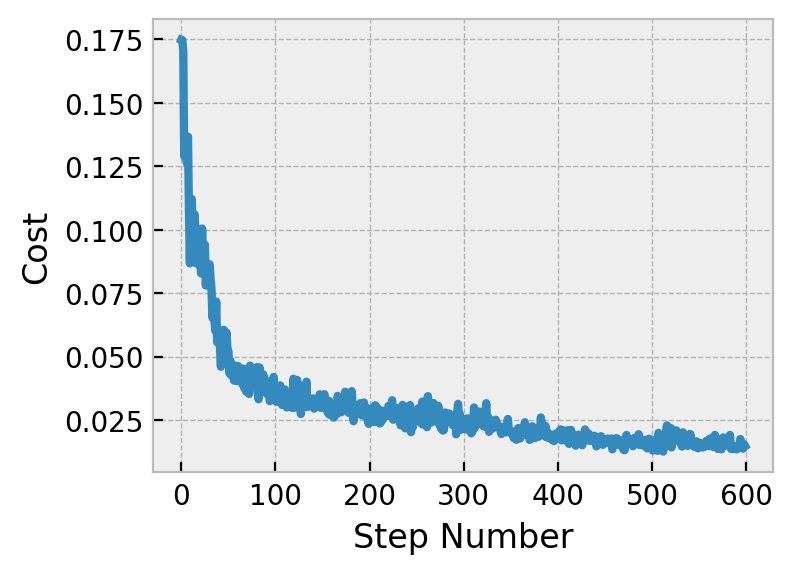

In [21]:
# training model using specified batchsize and step size
steps=600
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=50,steps=steps)
# plot cost against step number of training
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost");
# output final cost value
print("Final Cost: ", cost[-1])

In [22]:
# output layers and neurons in model
print_layers(model,y_target)

Layer 0: 23328 neurons /  (50, 27, 27, 32)
Layer 1: 2592 neurons /  (50, 9, 9, 32)
Layer 2: 2592 neurons /  (50, 9, 9, 32)
Layer 3: 288 neurons /  (50, 3, 3, 32)
Layer 4: 27 neurons /  (50, 3, 3, 3)
Layer 5: 3 neurons /  (50, 1, 1, 3)
Layer 6: 27 neurons /  (50, 3, 3, 3)
Layer 7: 288 neurons /  (50, 3, 3, 32)
Layer 8: 2592 neurons /  (50, 9, 9, 32)
Layer 9: 2592 neurons /  (50, 9, 9, 32)
Layer 10: 23328 neurons /  (50, 27, 27, 32)
Layer 11: 2187 neurons /  (50, 27, 27, 3)


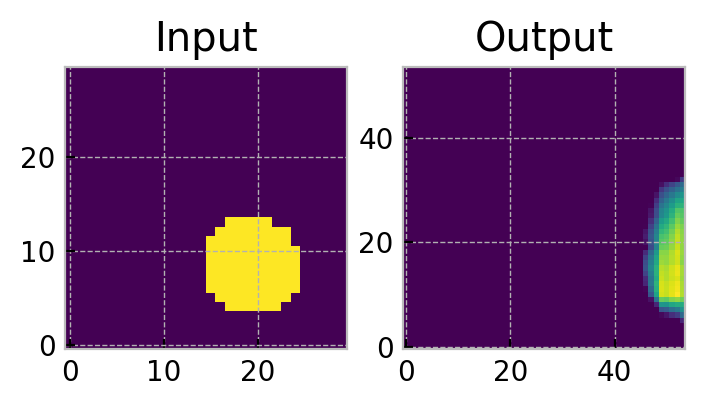

In [30]:
# display a test input and outp|ut image
plot_test_image(model,circle_generator,30)

Finally, we see that we are able to achieve a much better cost function of <0.015 despite making this network simpler and more efficient than the previous model for this task. However, the output image is not as visually good as we were able to achieve in the previous Task. 

## Summary

We see that we can use autoencoders to attempt to regenerate the input image provided to our network in an unsupervised learning task. We have also seen that the performance of our autoencoders for this specific problem has given a higher performance with a 'bottleneck' of 9 neurons than the '3 neurons'. We were able to achieve a cost value of ~0.013 for Task 1 and ~0.015 for Task 2, although the output images are visually much better for Task 1 than Task 2. 